In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

from xgboost import XGBClassifier, plot_importance as xg_importance
from lightgbm import LGBMClassifier, plot_importance as lgb_importance

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [5]:
data = pd.read_csv('./creditcard.csv')

In [6]:
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

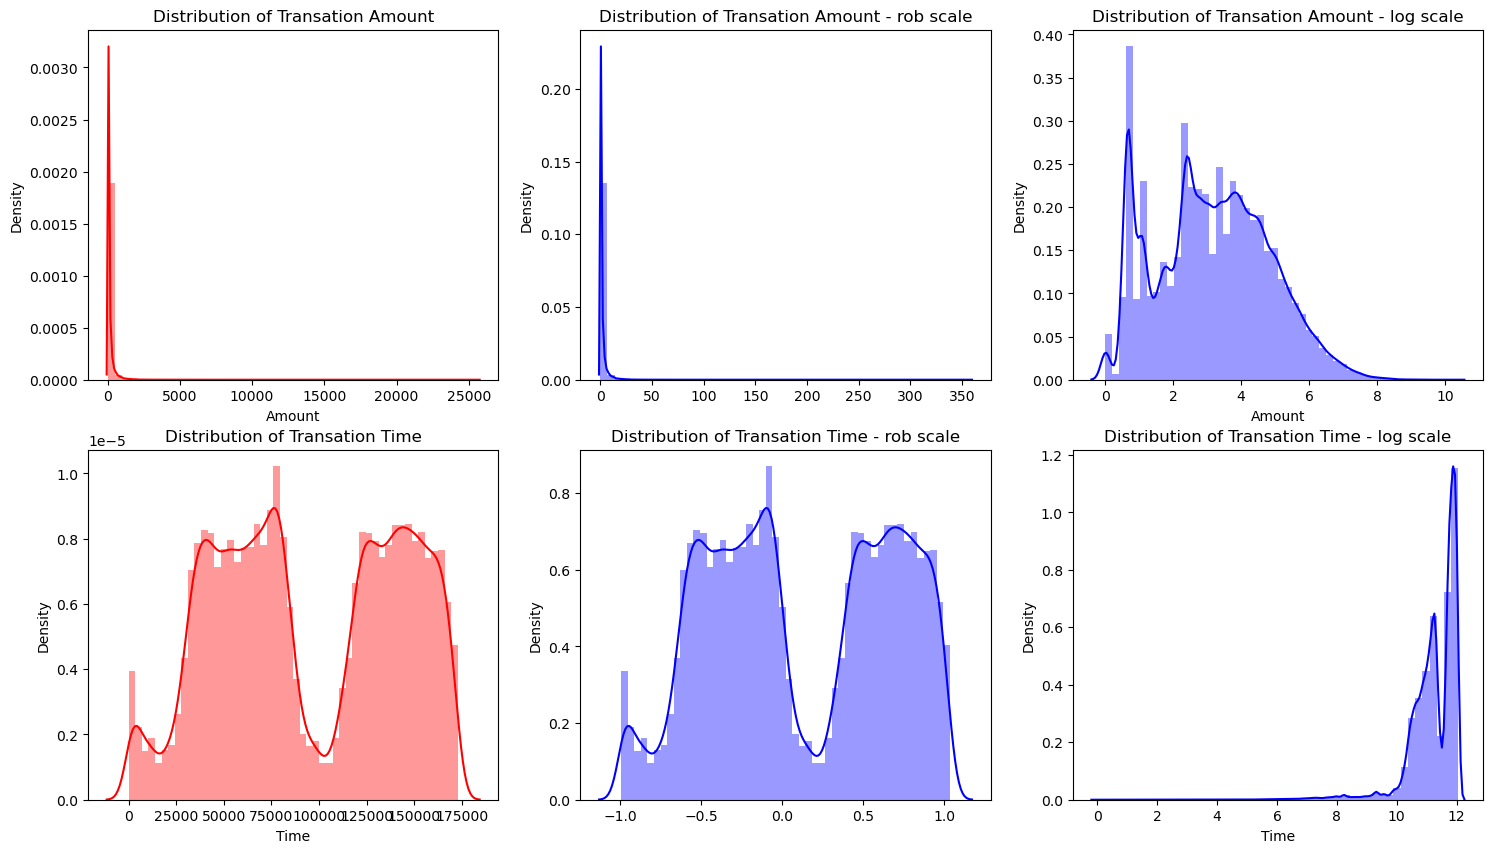

In [25]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))
amount_val = data['Amount'].values
time_val = data['Time'].values

col = ['Amount', 'Time']

for i, col in enumerate(col):
    sns.distplot(data[col], ax=ax[i][0], color='r')
    if col == 'Amount':
        sns.distplot(rob_scaler.fit_transform(data[col].values.reshape(-1, 1)), ax=ax[i][1], color='b')
        sns.distplot(np.log1p(data[col]), ax=ax[i][2], color='b')
    elif col == 'Time':
        sns.distplot(rob_scaler.fit_transform(data[col].values.reshape(-1, 1)), ax=ax[i][1], color='b')
        sns.distplot(np.log1p(data[col]), ax=ax[i][2], color='b')
    else:
        pass

    ax[i][0].set_title(f"Distribution of Transation {col}")
    ax[i][1].set_title(f"Distribution of Transation {col} - rob scale")
    ax[i][2].set_title(f"Distribution of Transation {col} - log scale")
    

plt.show()

In [28]:
data_case_1 = data.copy()
data_case_2 = data.copy()

'''case 1 = amount에 대해서 rob scale'''
data_case_1['scaled_amount'] = rob_scaler.fit_transform(data['Amount'].values.reshape(-1, 1))
'''case 2 = amount에 대해서 log scale'''
data_case_2['scaled_amount'] = np.log1p(data['Amount'])

data_case_1['scaled_time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1, 1))
data_case_2['scaled_time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1, 1))

In [29]:
data_case_1.drop(['Time', 'Amount'], axis=1, inplace=True)
data_case_2.drop(['Time', 'Amount'], axis=1, inplace=True)

In [30]:
scaled_amount_case1 = data_case_1['scaled_amount']
scaled_amount_case2 = data_case_2['scaled_amount']

scaled_time_case1 = data_case_1['scaled_time']
scaled_time_case2 = data_case_2['scaled_time']

data_case_1.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
data_case_2.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)

data_case_1.insert(0, 'scaled_amount', scaled_amount_case1)
data_case_1.insert(1, 'scaled_time', scaled_time_case1)

data_case_2.insert(0, 'scaled_amount', scaled_amount_case2)
data_case_2.insert(1, 'scaled_time', scaled_time_case2)


In [31]:
data_case_1.head()

scaled_amount  scaled_time        V1        V2        V3        V4   
0       1.783274    -0.994983 -1.359807 -0.072781  2.536347  1.378155  \
1      -0.269825    -0.994983  1.191857  0.266151  0.166480  0.448154   
2       4.983721    -0.994972 -1.358354 -1.340163  1.773209  0.379780   
3       1.418291    -0.994972 -0.966272 -0.185226  1.792993 -0.863291   
4       0.670579    -0.994960 -1.158233  0.877737  1.548718  0.403034   

         V5        V6        V7        V8  ...       V20       V21       V22   
0 -0.338321  0.462388  0.239599  0.098698  ...  0.251412 -0.018307  0.277838  \
1  0.060018 -0.082361 -0.078803  0.085102  ... -0.069083 -0.225775 -0.638672   
2 -0.503198  1.800499  0.791461  0.247676  ...  0.524980  0.247998  0.771679   
3 -0.010309  1.247203  0.237609  0.377436  ... -0.208038 -0.108300  0.005274   
4 -0.407193  0.095921  0.592941 -0.270533  ...  0.408542 -0.009431  0.798278   

        V23       V24       V25       V26       V27       V28  Class  
0 -0.110474  0.066928  0.128539 -0.189115  0.133558 -0.021053      0  
1  0.101288 -0.339846  0.167170  0.125895 -0.008983  0.014724      0  
2  0.909412 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752      0  
3 -0.190321 -1.175575  0.647376 -0.221929  0.062723  0.061458      0  
4 -0.137458  0.141267 -0.206010  0.502292  0.219422  0.215153      0  

[5 rows x 31 columns]

In [32]:
data_case_2.head()

scaled_amount  scaled_time        V1        V2        V3        V4   
0       5.014760    -0.994983 -1.359807 -0.072781  2.536347  1.378155  \
1       1.305626    -0.994983  1.191857  0.266151  0.166480  0.448154   
2       5.939276    -0.994972 -1.358354 -1.340163  1.773209  0.379780   
3       4.824306    -0.994972 -0.966272 -0.185226  1.792993 -0.863291   
4       4.262539    -0.994960 -1.158233  0.877737  1.548718  0.403034   

         V5        V6        V7        V8  ...       V20       V21       V22   
0 -0.338321  0.462388  0.239599  0.098698  ...  0.251412 -0.018307  0.277838  \
1  0.060018 -0.082361 -0.078803  0.085102  ... -0.069083 -0.225775 -0.638672   
2 -0.503198  1.800499  0.791461  0.247676  ...  0.524980  0.247998  0.771679   
3 -0.010309  1.247203  0.237609  0.377436  ... -0.208038 -0.108300  0.005274   
4 -0.407193  0.095921  0.592941 -0.270533  ...  0.408542 -0.009431  0.798278   

        V23       V24       V25       V26       V27       V28  Class  
0 -0.110474  0.066928  0.128539 -0.189115  0.133558 -0.021053      0  
1  0.101288 -0.339846  0.167170  0.125895 -0.008983  0.014724      0  
2  0.909412 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752      0  
3 -0.190321 -1.175575  0.647376 -0.221929  0.062723  0.061458      0  
4 -0.137458  0.141267 -0.206010  0.502292  0.219422  0.215153      0  

[5 rows x 31 columns]

In [33]:
print(data_case_1.iloc[:, -1].value_counts() / data.iloc[:, -1].count() * 100)
print(data_case_2.iloc[:, -1].value_counts() / data.iloc[:, -1].count() * 100)


Class
0    99.827251
1     0.172749
Name: count, dtype: float64
Class
0    99.827251
1     0.172749
Name: count, dtype: float64


In [34]:
X_1 = data_case_1.iloc[:, :-1]
y_1 = data_case_1.iloc[:, -1]

X_2 = data_case_2.iloc[:, :-1]
y_2 = data_case_2.iloc[:, -1]

In [35]:
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size = 0.25, random_state=0, stratify = y_1)
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size = 0.25, random_state=0, stratify = y_2)

In [37]:
print(y_1_train.value_counts() / y_1_train.count() * 100)
print(y_1_test.value_counts() / y_1_test.count() * 100)

print(y_2_train.value_counts() / y_2_train.count() * 100)
print(y_2_test.value_counts() / y_2_test.count() * 100)

Class
0    99.827251
1     0.172749
Name: count, dtype: float64
Class
0    99.827252
1     0.172748
Name: count, dtype: float64
Class
0    99.827251
1     0.172749
Name: count, dtype: float64
Class
0    99.827252
1     0.172748
Name: count, dtype: float64


In [38]:
def modeling(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    metrics(y_test, pred)

In [39]:
def metrics(y_test, pred):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_score = roc_auc_score(y_test, pred)
    print('정확도 : {0:.2f}, 정밀도 : {1:.2f}, 재현율 : {2:.2f}'.format(accuracy, precision, recall))
    print('f1-score : {0:.2f}, auc : {1:.2f}'.format(f1, roc_score))

In [40]:
lr = LogisticRegression()
modeling(lr, X_1_train, X_1_test, y_1_train, y_1_test)

정확도 : 1.00, 정밀도 : 0.85, 재현율 : 0.66
f1-score : 0.74, auc : 0.83


In [41]:
modeling(lr, X_2_train, X_2_test, y_2_train, y_2_test)

정확도 : 1.00, 정밀도 : 0.88, 재현율 : 0.64
f1-score : 0.74, auc : 0.82


In [42]:
lgb = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
modeling(lgb, x_train = X_1_train, x_test = X_1_test, y_train = y_1_train, y_test = y_1_test)

정확도 : 1.00, 정밀도 : 0.94, 재현율 : 0.76
f1-score : 0.84, auc : 0.88


In [43]:
modeling(lgb, x_train = X_2_train, x_test = X_2_test, y_train = y_2_train, y_test = y_2_test)

정확도 : 1.00, 정밀도 : 0.96, 재현율 : 0.77
f1-score : 0.86, auc : 0.89


In [44]:
'''
case 1 : amount에 대해서 rob scale
case 2 : amount에 대해서 log scale

같은 모델에 대해서 결과 값이 크게 다르지 않음 
'''

'\ncase 1 : amount에 대해서 rob scale\ncase 2 : amount에 대해서 log scale\n\n같은 모델에 대해서 결과 값이 크게 다르지 않음 \n'